# Undistort Dataset
[https://github.com/jayrambhia/Vision/blob/master/OpenCV/C%2B%2B/stereocalibrate.cpp](https://github.com/jayrambhia/Vision/blob/master/OpenCV/C%2B%2B/stereocalibrate.cpp)

In [1]:
class Args:
    uncalibrated_dataset_path = "../../resources/images/uncalibrated/calibration_dataset.npz"
    calibrated_dataset_path = "../../resources/images/calibrated/dataset_1.npz"
    calibration_matrix_path = "../../resources/calibrations/calibration.yml"
    save_calibrated_images = False
    common_points_threshold = 60
args = Args()

In [2]:
from models.dataset.dataset_interface import open_dataset
from models.dataset.undistort import undistort_images
from models.calibration.calibrate_extrinsics import calibrate_extrinsics
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [14]:
rs_rgb, rs_z, rs_cm, rs_dc, zv_rgb, zv_z, zv_cm, zv_dc = open_dataset(args.uncalibrated_dataset_path)
print(f"Opened dataset containing {len(rs_rgb)} image sets")

# image sizes of realsense and zivid
img_rs_size = tuple(reversed(rs_rgb[0].shape[:2]))
img_zv_size = tuple(reversed(rs_rgb[0].shape[:2]))

# charuco board configuration
charuco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50) 
charuco_board = cv2.aruco.CharucoBoard_create(7, 5, 7.5, 5.625, charuco_dict)

# get extrinsic transformation between both cameras
R, T = calibrate_extrinsics(
    charuco_dict=charuco_dict, 
    charuco_board=charuco_board, 
    common_points_threshold=args.common_points_threshold, 
    imgs_1=rs_rgb,
    imgs_1_cm=rs_cm,
    imgs_1_dc=rs_dc,
    imgs_2=zv_rgb,
    imgs_2_cm=zv_cm,
    imgs_2_dc=zv_dc
)

print("R")
print(R)
print("T")
print(T)

Opened dataset containing 24 image sets
R
[[ 0.95929003 -0.03724781 -0.27995578]
 [ 0.02789767  0.99891422 -0.03731091]
 [ 0.28104156  0.02798187  0.95928758]]
T
[[-0.56688469]
 [ 9.44296411]
 [ 4.2928518 ]]


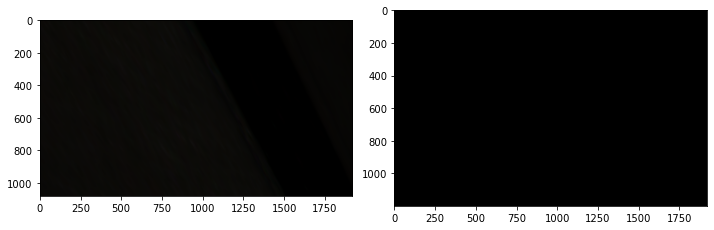

In [13]:
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(rs_cm, rs_dc, zv_cm, zv_dc, img_rs_size, R, T)
map1x, map1y = cv2.initUndistortRectifyMap(rs_cm, rs_dc, R1, P1, img_rs_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(zv_cm, zv_dc, R2, P2, img_zv_size, cv2.CV_32FC1)
img1 = rs_rgb[4]
img2 = zv_rgb[4]

imgU1 = cv2.remap(img1, map1x, map1y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
imgU2 = cv2.remap(img2, map2x, map2y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
f, axarr = plt.subplots(1, 2, figsize=(10, 20))
f.tight_layout()
axarr[0].imshow(imgU1)
axarr[1].imshow(imgU2)